# **Installations**

In [8]:
# Installations
!pip install adversarial-robustness-toolbox
!pip install tensorflow==2.13.0

# **Imports**

In [9]:
# Imports

# for dataset
from tensorflow.keras.utils import to_categorical
from art.utils import load_dataset

# for model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
import keras.backend as k

# for attack
import warnings
import numpy as np
import tensorflow as tf
from numpy.random import seed
from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()
warnings.filterwarnings('ignore')
seed(123)

# **Data Preprocessing**

Trainset 1 shape: (25000, 32, 32, 1), Trainset 2 shape: (25000, 32, 32, 1)
Testset 1 shape: (5000, 32, 32, 1), Testset 2 shape: (5000, 32, 32, 1)


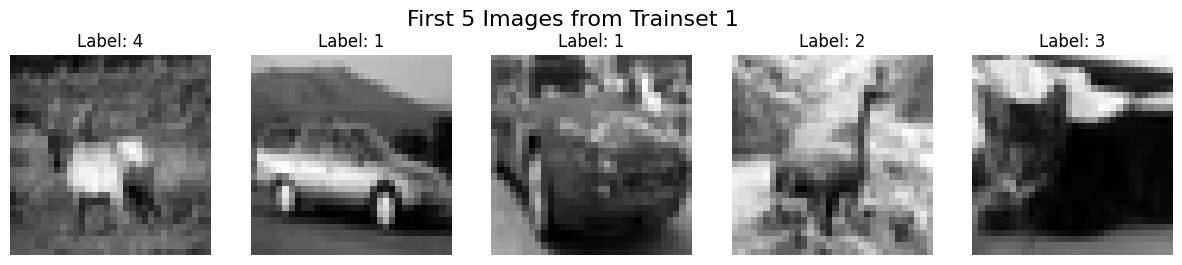

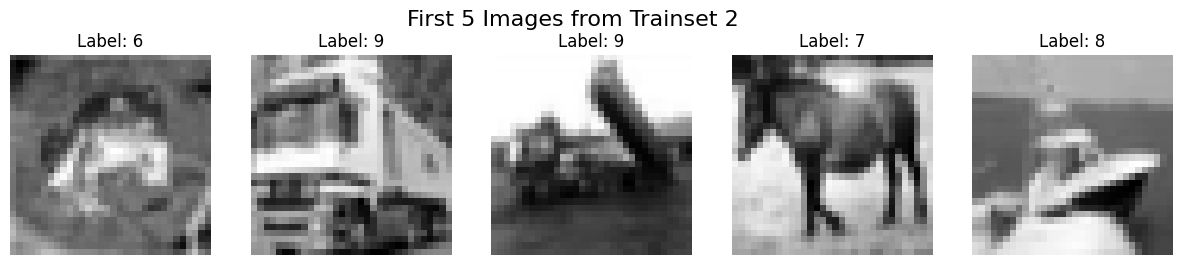

In [10]:
# Data Preprocessing

# Load CIFAR-10 dataset and convert to grayscale
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset("cifar10")

# Convert CIFAR-10 to grayscale
x_train = np.dot(x_train[...,:3], [0.2989, 0.5870, 0.1140])  # RGB to grayscale
x_train = x_train[..., np.newaxis]  # Add channel dimension

x_test = np.dot(x_test[...,:3], [0.2989, 0.5870, 0.1140])  # RGB to grayscale
x_test = x_test[..., np.newaxis]  # Add channel dimension

# Convert one-hot encoded labels to class indices
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Split the CIFAR-10 training set based on the first 5 and second 5 labels
trainset1_indices = np.isin(y_train_classes, [0, 1, 2, 3, 4])  # First 5 labels
trainset2_indices = np.isin(y_train_classes, [5, 6, 7, 8, 9])  # Second 5 labels

x_train_set1 = x_train[trainset1_indices]
y_train_set1 = y_train[trainset1_indices]

x_train_set2 = x_train[trainset2_indices]
y_train_set2 = y_train[trainset2_indices]

# Split the CIFAR-10 test set based on the first 5 and second 5 labels
testset1_indices = np.isin(y_test_classes, [0, 1, 2, 3, 4])  # First 5 labels
testset2_indices = np.isin(y_test_classes, [5, 6, 7, 8, 9])  # Second 5 labels

x_test_set1 = x_test[testset1_indices]
y_test_set1 = y_test[testset1_indices]

x_test_set2 = x_test[testset2_indices]
y_test_set2 = y_test[testset2_indices]

# Print the shape of the datasets to verify
print(f"Trainset 1 shape: {x_train_set1.shape}, Trainset 2 shape: {x_train_set2.shape}")
print(f"Testset 1 shape: {x_test_set1.shape}, Testset 2 shape: {x_test_set2.shape}")

# Function to plot images
def plot_images(images, labels, title, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {np.argmax(labels[i])}")  # Display the label
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()
# Plot the first 5 images from Trainset 1
plot_images(x_train_set1, y_train_set1, title="First 5 Images from Trainset 1")
# Plot the first 5 images from Trainset 2
plot_images(x_train_set2, y_train_set2, title="First 5 Images from Trainset 2")


# **Before Federated Learning**

In [13]:
def cnn_cifar10(input_shape, min_val, max_val):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    classifier = KerasClassifier(clip_values=(min_val, max_val), model=model, use_logits=False)
    return classifier

num_epochs = 10
classifier1 = cnn_cifar10(x_train_set1.shape[1:], min_, max_)
classifier1.fit(x_train_set1, y_train_set1, nb_epochs=num_epochs, batch_size=128)
predictions_set1 = classifier1.predict(x_test_set1)
predicted_labels_set1 = np.argmax(predictions_set1, axis=1)  # Convert probabilities to class labels
# Calculate accuracy for test set 1
accuracy_set1 = np.mean(predicted_labels_set1 == np.argmax(y_test_set1, axis=1))
print(f"Test Set 1 - Accuracy: {accuracy_set1:.4f}")

classifier2 = cnn_cifar10(x_train_set2.shape[1:], min_, max_)
classifier2.fit(x_train_set2, y_train_set2, nb_epochs=num_epochs, batch_size=128)
predictions_set2 = classifier2.predict(x_test_set2)
predicted_labels_set2 = np.argmax(predictions_set2, axis=1)  # Convert probabilities to class labels
# Calculate accuracy for test set 2
accuracy_set2 = np.mean(predicted_labels_set2 == np.argmax(y_test_set2, axis=1))
print(f"Test Set 2 - Accuracy: {accuracy_set2:.4f}")

Test Set 1 - Accuracy: 0.7092
Test Set 2 - Accuracy: 0.8184


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

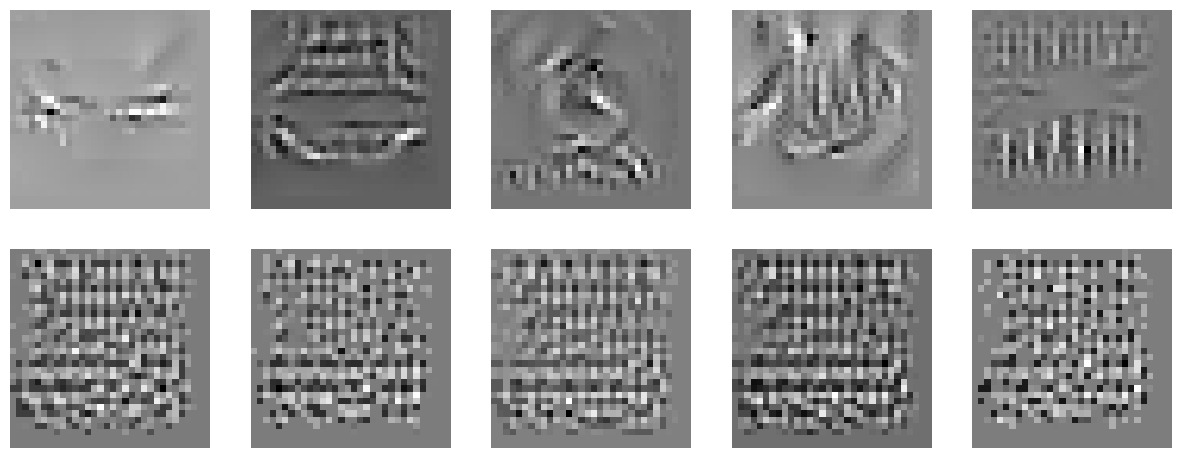

In [14]:
# For classifier1
# Create the model inversion attack
attack = MIFace(classifier1, max_iter=10000, threshold=1.)
# Target to infer information about the training samples for each of the 10 CIFAR-10 classes
y = np.arange(10)
x_init_grey = np.zeros((10, 32, 32, 1)) + 0.5
x_infer_from_grey = attack.infer(x_init_grey, y)
# Display inferred images
plt.figure(figsize=(15, 15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(x_infer_from_grey[i], (32, 32)), cmap=plt.cm.gray_r)
    plt.axis('off')
plt.show()
# We could find the reshaping of below labels
# ------------------------
# Label0 - Aeroplane
# Label1 - Automobile
# Label2 - Bird
# Label3 - Cat
# Label4 - Deer
# -------------------------

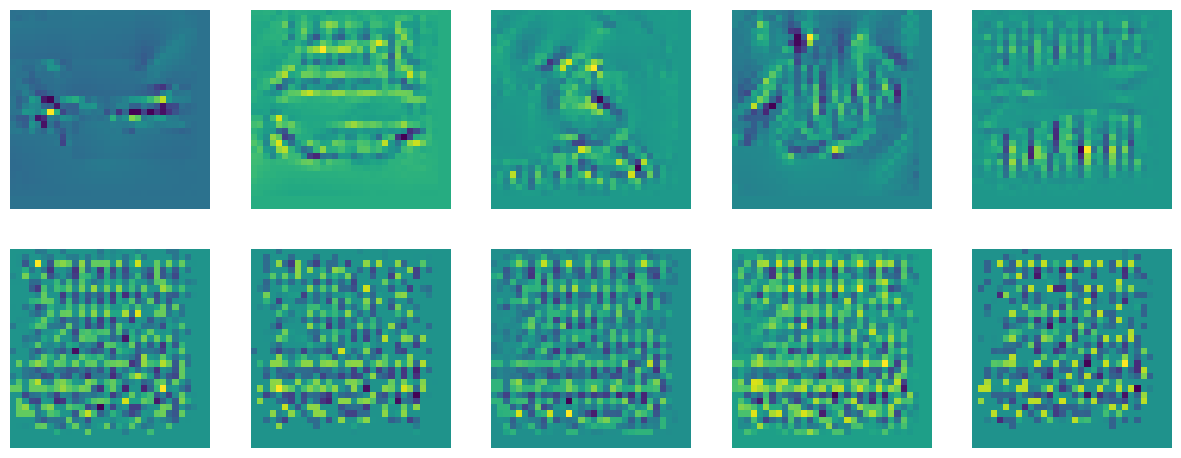

In [16]:
plt.figure(figsize=(15, 15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(x_infer_from_grey[i], (32, 32)), cmap=plt.cm.viridis)
    plt.axis('off')
plt.show()

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

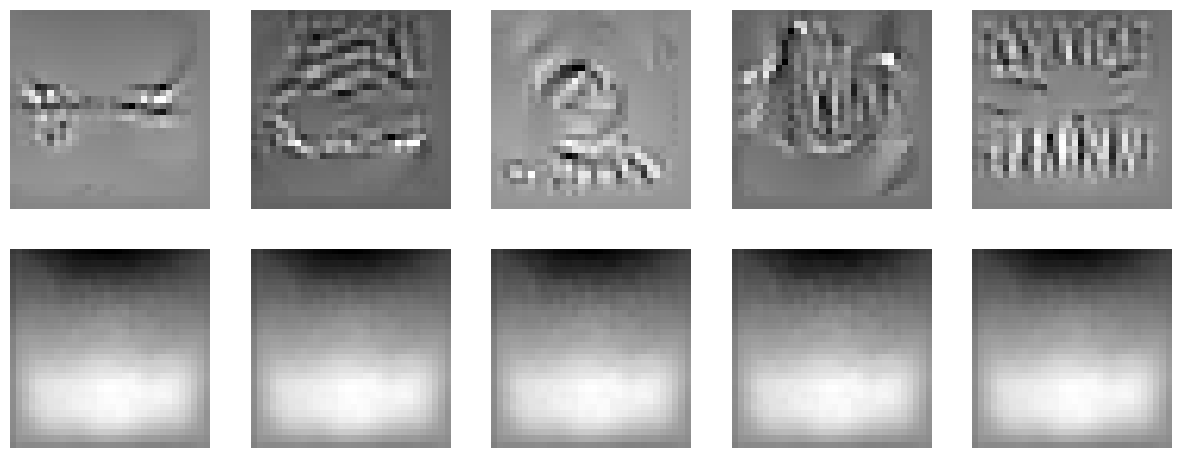

In [15]:
# For classifier1
# Create the model inversion attack
attack = MIFace(classifier1, max_iter=10000, threshold=1.)
# Target to infer information about the training samples for each of the 10 CIFAR-10 classes
y = np.arange(10)
x_init_average = np.zeros((10, 32, 32, 1)) + np.mean(x_test, axis=0) # Mean of test images
x_infer_from_average = attack.infer(x_init_average, y)
# Display inferred images
plt.figure(figsize=(15, 15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(x_infer_from_average[i], (32, 32)), cmap=plt.cm.gray_r)
    plt.axis('off')
plt.show()
# ------------------------
# Label0 - Aeroplane
# Label1 - Automobile
# Label2 - Bird
# Label3 - Cat
# Label4 - Deer
# -------------------------

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

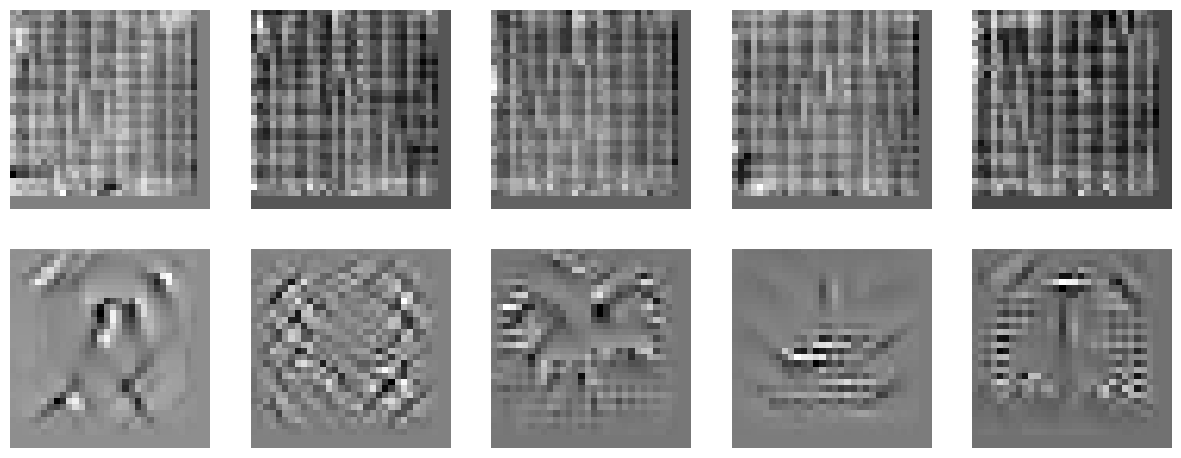

In [17]:
# For classifier2
# Create the model inversion attack
attack = MIFace(classifier2, max_iter=10000, threshold=1.)
# Target to infer information about the training samples for each of the 10 CIFAR-10 classes
y = np.arange(10)
x_init_grey = np.zeros((10, 32, 32, 1)) + 0.5
x_infer_from_grey = attack.infer(x_init_grey, y)
# Display inferred images
plt.figure(figsize=(15, 15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(x_infer_from_grey[i], (32, 32)), cmap=plt.cm.gray_r)
    plt.axis('off')
plt.show()
# We could find the reshaping of below labels
# ------------------------
# Label5 - Dog
# Label6 - Frog
# Label7 - Horse
# Label8 - Ship
# Label9 - Truck
# -------------------------

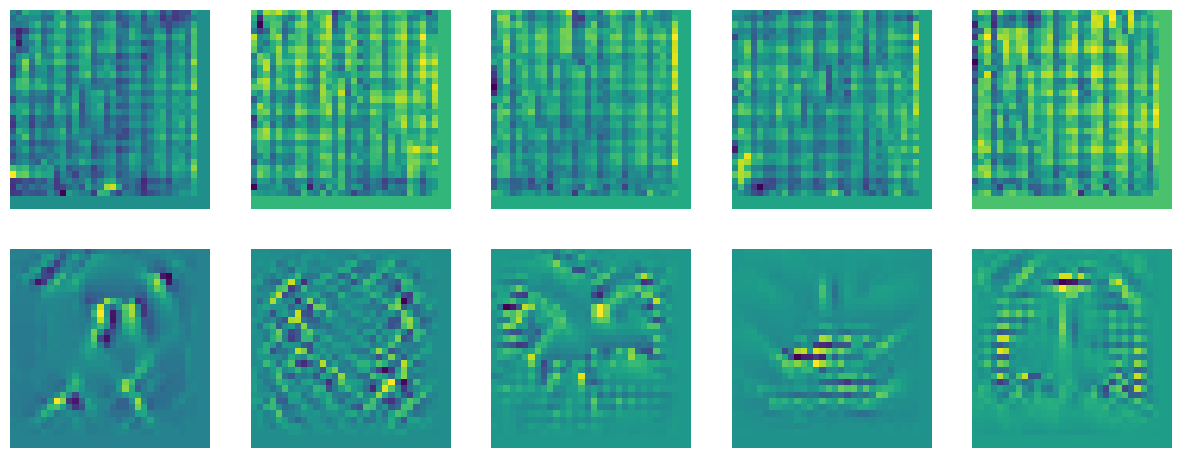

In [19]:
plt.figure(figsize=(15, 15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(x_infer_from_grey[i], (32, 32)), cmap=plt.cm.viridis)
    plt.axis('off')
plt.show()

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

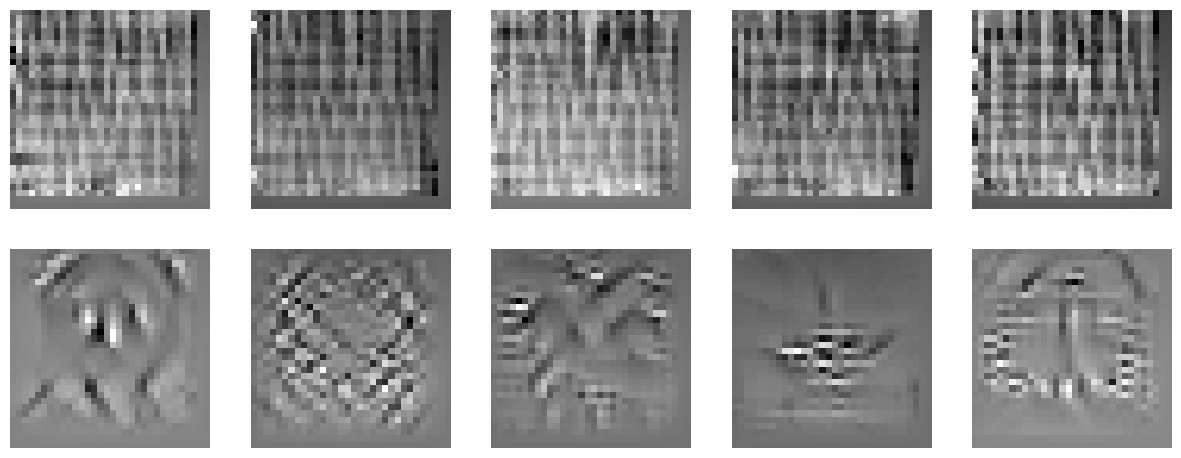

In [18]:
# For classifier2
# Create the model inversion attack
attack = MIFace(classifier2, max_iter=10000, threshold=1.)
# Target to infer information about the training samples for each of the 10 CIFAR-10 classes
y = np.arange(10)
x_init_average = np.zeros((10, 32, 32, 1)) + np.mean(x_test, axis=0) # Mean of test images
x_infer_from_average = attack.infer(x_init_average, y)
# Display inferred images
plt.figure(figsize=(15, 15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(x_infer_from_average[i], (32, 32)), cmap=plt.cm.gray_r)
    plt.axis('off')
plt.show()
# ------------------------
# Label5 - Dog
# Label6 - Frog
# Label7 - Horse
# Label8 - Ship
# Label9 - Truck
# -------------------------

# **Apply Federated Learning**

In [11]:
# FL setup

# Declare the model

def model(input_shape, min_val, max_val):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    classifier = KerasClassifier(clip_values=(min_val, max_val),model=model, use_logits=False)
    return classifier

# Perform FED-AVG
def aggregated_weights(client1_weights,client2_weights):
    new_weights = []
    for w_client1, w_client2 in zip(client1_weights, client2_weights):
        avg_weight = (w_client1 + w_client2) / 2.0
        new_weights.append(avg_weight)
    return new_weights

# Initialize the model
# Client1
client1_model = model(x_train_set1.shape[1:], 0, 1)
# Client2
client2_model = model(x_train_set2.shape[1:], 0, 1)
# Converged model
converged_model = model(x_train_set1.shape[1:], 0, 1)

for round_num in range(10):
    print(f"Communication Round {round_num + 1}")

    # Train the model
    # Client 1 trains locally
    client1_model.fit(x_train_set1, y_train_set1, nb_epochs=5, batch_size=128, verbose=0)
    # Client 2 trains locally
    client2_model.fit(x_train_set2, y_train_set2, nb_epochs=5, batch_size=128, verbose=0)

    # Test the model
    # Client1
    predictions_set1 = client1_model.predict(x_test_set1)
    predicted_labels_set1 = np.argmax(predictions_set1, axis=1)  # Convert probabilities to class labels
    accuracy_set1 = np.mean(predicted_labels_set1 == np.argmax(y_test_set1, axis=1))
    print(f"Test Set 1 - Accuracy: {accuracy_set1:.4f}")
    # Client2
    predictions_set2 = client2_model.predict(x_test_set2)
    predicted_labels_set2 = np.argmax(predictions_set2, axis=1)  # Convert probabilities to class labels
    accuracy_set1 = np.mean(predicted_labels_set2 == np.argmax(y_test_set2, axis=1))
    print(f"Test Set 2 - Accuracy: {accuracy_set1:.4f}")

    # Combine weights
    # Get client weights
    # Get client 1's and client 2's weights
    client1_weights = client1_model.model.get_weights()
    client2_weights = client2_model.model.get_weights()
    # FedAvg: Average the weights of both clients
    new_weights=aggregated_weights(client1_weights,client2_weights)
    # Update both models with the averaged weights (synchronizing them)
    client1_model.model.set_weights(new_weights)
    client2_model.model.set_weights(new_weights)

    converged_model.model.set_weights(new_weights)

Communication Round 1
Test Set 1 - Accuracy: 0.5816
Test Set 2 - Accuracy: 0.7308
Communication Round 2
Test Set 1 - Accuracy: 0.6102
Test Set 2 - Accuracy: 0.7194
Communication Round 3
Test Set 1 - Accuracy: 0.6354
Test Set 2 - Accuracy: 0.7434
Communication Round 4
Test Set 1 - Accuracy: 0.6596
Test Set 2 - Accuracy: 0.7790
Communication Round 5
Test Set 1 - Accuracy: 0.6694
Test Set 2 - Accuracy: 0.7916
Communication Round 6
Test Set 1 - Accuracy: 0.6914
Test Set 2 - Accuracy: 0.8014
Communication Round 7
Test Set 1 - Accuracy: 0.7018
Test Set 2 - Accuracy: 0.8016
Communication Round 8
Test Set 1 - Accuracy: 0.7072
Test Set 2 - Accuracy: 0.8140
Communication Round 9
Test Set 1 - Accuracy: 0.7188
Test Set 2 - Accuracy: 0.8182
Communication Round 10
Test Set 1 - Accuracy: 0.7274
Test Set 2 - Accuracy: 0.8280


Here, we could find the reconstructions of Aeroplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck - We could find its shape

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

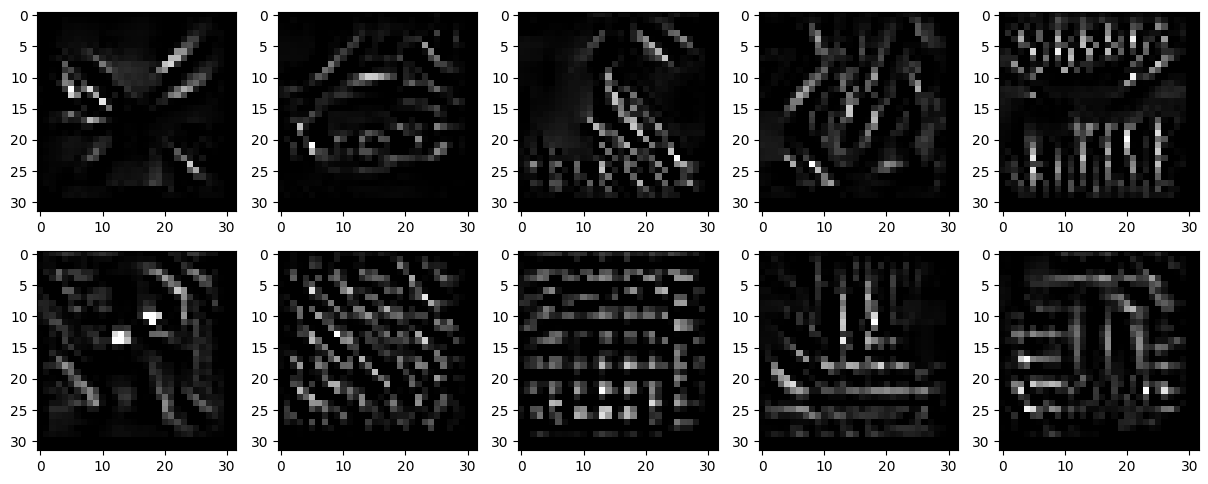

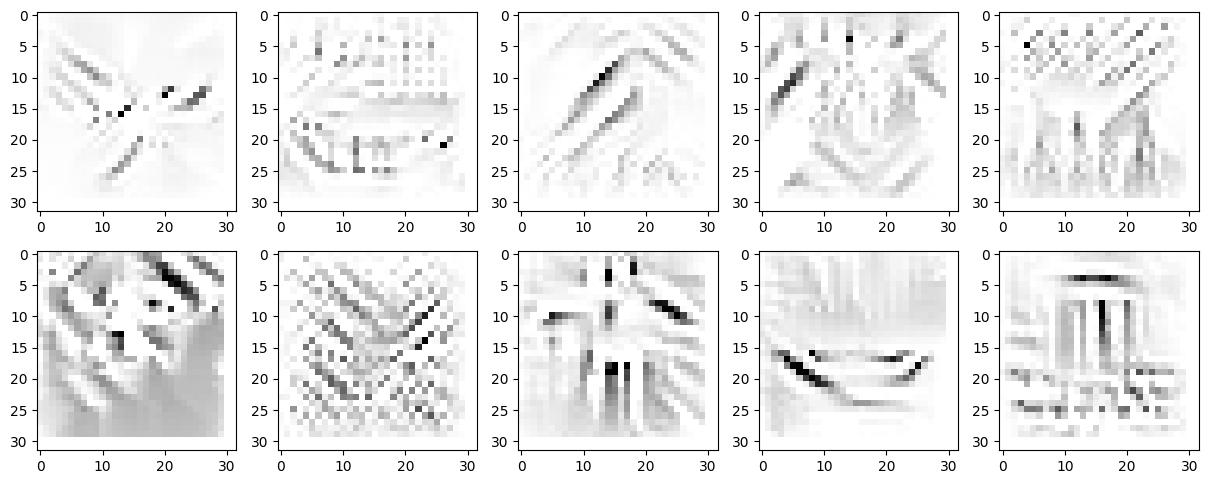

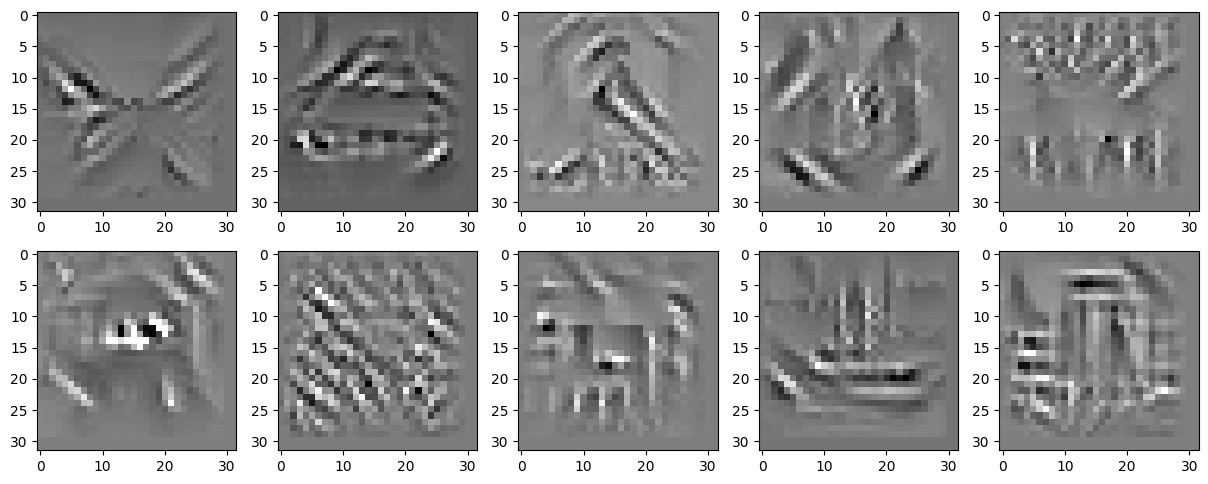

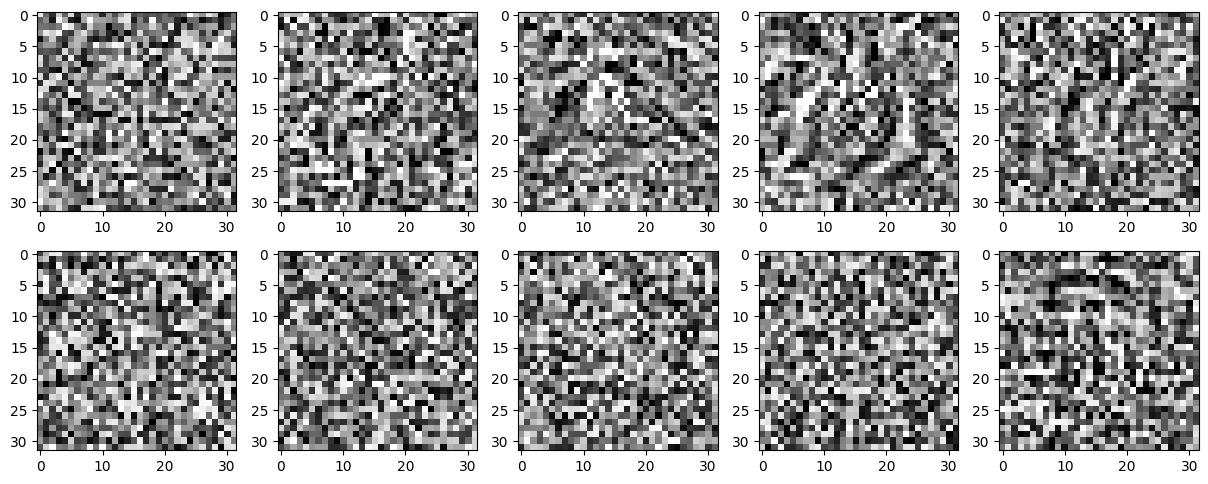

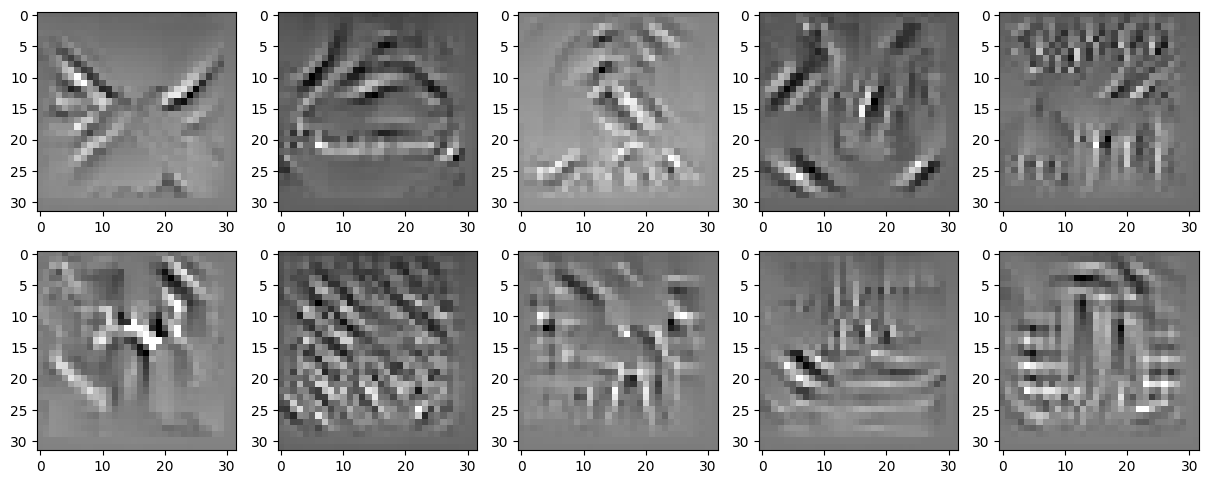

In [13]:
# Model Inversion Attack on Converged model

# Create the attack
attack = MIFace(converged_model, max_iter=20000, threshold=1.5)
# for each 10 MNIST classes
y = np.arange(10)


# Experiment on Black Sample
x_init_black = np.ones((10, 32, 32, 1))
# Run the attack
x_infer_from_black = attack.infer(x_init_black, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_black[0+i,], (32, 32))), cmap=plt.cm.gray_r)


# Experiment on White Sample
x_init_white = np.zeros((10, 32, 32, 1))
# Run the attack
x_infer_from_white = attack.infer(x_init_white, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_white[0+i,], (32, 32))), cmap=plt.cm.gray_r)


# Experiment on Grey Sample
x_init_grey = np.zeros((10,32, 32, 1)) + 0.5
# Run the attack
x_infer_from_grey = attack.infer(x_init_grey, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (32, 32))), cmap=plt.cm.gray_r)


# Experiment on Random Sample
x_init_random = np.random.uniform(0, 1, (10, 32, 32, 1))
# Run the attack
x_infer_from_random = attack.infer(x_init_random, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_random[0+i,], (32, 32))), cmap=plt.cm.gray_r)


# Experiment on Average Sample
x_init_average = np.zeros((10, 32, 32, 1)) + np.mean(x_test, axis=0)
# Run the attack
x_infer_from_average = attack.infer(x_init_average, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_average[0+i,], (32, 32))), cmap=plt.cm.gray_r)

# **Defense**
For defense it just encrypts the weights of the model, which is explained in defense_fl file. It doesn't depend on the dataset.